<a href="https://colab.research.google.com/github/simon-clematide/colab-notebooks-for-teaching/blob/main/word2vec_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simplified Word2Vec Skipgram Training
Source: https://github.com/minsuk-heo/python_tutorial/blob/master/data_science/nlp/word2vec_tensorflow.ipynb

# Collect Data
we will use only 10 sentences to create word vectors

In [1]:
corpus = ['king is a strong man',
          'queen is a wise woman',
          'queen is an important woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen',
          'prince is a strong boy',
          'princess is a strong girl',
          'football is a nice sport',
          'basketball is a sport for strong king'
          ]

# Remove stop words
In order for efficiency of creating word vector, we will remove commonly used words

In [2]:
def remove_stop_words(corpus):
    stop_words = ['is', 'a', 'an', 'will', 'be']
    results = []
    for text in corpus:
        tmp = text.split(' ')
        for stop_word in stop_words:
            if stop_word in tmp:
                tmp.remove(stop_word)
        results.append(" ".join(tmp))

    return results

In [3]:
corpus = remove_stop_words(corpus)

In [4]:
words = set()
for text in corpus:
    for word in text.split(' '):
        words.add(word)

words = sorted(words)

here we have a vocabulary list by which we will have a word vector

In [5]:
words

['basketball',
 'boy',
 'football',
 'for',
 'girl',
 'important',
 'king',
 'man',
 'nice',
 'pretty',
 'prince',
 'princess',
 'queen',
 'sport',
 'strong',
 'wise',
 'woman',
 'young']

# Data generation
Skipgram: From center word, predict context words within a certain window.

Each one-hot encoded word is represented by an integer (the index of the 1 in  the concept of of a one-hot vector)

The automatic data generation plus learning is called self-supervised learning, as no explicit manual labeling is needed. Some people call it unsupervised learning, but that's technically wrong.

In [6]:
word2int = {}

# each word gets its number from the set 'words'
for i,word in enumerate(words):
    word2int[word] = i

# sentences is a list of lists of words
sentences = []
for sentence in corpus:
    sentences.append(sentence.split())

WINDOW_SIZE = 2

data = []
for sentence in sentences:
    for idx, word in enumerate(sentence):
        for neighbor in sentence[max(idx - WINDOW_SIZE, 0) : min(idx + WINDOW_SIZE, len(sentence)) + 1] :
            if neighbor != word:
                data.append([word, neighbor])

In [7]:
import pandas as pd
for text in corpus:
    print(text)

df = pd.DataFrame(data, columns = ['input', 'label'])

king strong man
queen wise woman
queen important woman
boy young man
girl young woman
prince young king
princess young queen
man strong
woman pretty
prince boy king
princess girl queen
prince strong boy
princess strong girl
football nice sport
basketball sport for strong king


In [8]:
df.head(20)

,input,label
0,king,strong
1,king,man
2,strong,king
3,strong,man
4,man,king
5,man,strong
6,queen,wise
7,queen,woman
8,wise,queen
9,wise,woman


In [9]:
df.shape

(90, 2)

In [10]:
word2int

{'basketball': 0,
 'boy': 1,
 'football': 2,
 'for': 3,
 'girl': 4,
 'important': 5,
 'king': 6,
 'man': 7,
 'nice': 8,
 'pretty': 9,
 'prince': 10,
 'princess': 11,
 'queen': 12,
 'sport': 13,
 'strong': 14,
 'wise': 15,
 'woman': 16,
 'young': 17}

# Define Tensorflow Graph

In [11]:
import tensorflow as tf
import numpy as np

# work around for the problem: module 'tensorflow' has no attribute 'placeholder'
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

ONE_HOT_DIM = len(words)

# function to convert numbers to one hot vectors
def to_one_hot_encoding(data_point_index):
    one_hot_encoding = np.zeros(ONE_HOT_DIM)
    one_hot_encoding[data_point_index] = 1
    return one_hot_encoding

X = [] # input word
Y = [] # target word

for x, y in zip(df['input'], df['label']):
    X.append(to_one_hot_encoding(word2int[ x ]))
    Y.append(to_one_hot_encoding(word2int[ y ]))

# convert them to numpy arrays
X_train = np.asarray(X)
Y_train = np.asarray(Y)

# making placeholders for X_train and Y_train
x = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))
y_label = tf.placeholder(tf.float32, shape=(None, ONE_HOT_DIM))

# word embedding will be 2 dimension for 2d visualization
EMBEDDING_DIM = 2

# hidden layer: which represents word vector eventually
W1 = tf.Variable(tf.random_normal([ONE_HOT_DIM, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([1])) #bias
hidden_layer = tf.add(tf.matmul(x,W1), b1)

# output layer
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, ONE_HOT_DIM]))
b2 = tf.Variable(tf.random_normal([1]))
prediction = tf.nn.softmax(tf.add( tf.matmul(hidden_layer, W2), b2))

# loss function: cross entropy
loss = tf.reduce_mean(-tf.reduce_sum(y_label * tf.log(prediction), axis=[1]))

# training operation
train_op = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

Instructions for updating:
non-resource variables are not supported in the long term


# Train

In [12]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

iteration = 30000
for i in range(iteration):
    # input is X_train which is one hot encoded word
    # label is Y_train which is one hot encoded neighbor word
    sess.run(train_op, feed_dict={x: X_train, y_label: Y_train})
    if i % 3000 == 0:
        print('iteration '+str(i)+' loss is : ', sess.run(loss, feed_dict={x: X_train, y_label: Y_train}))

iteration 0 loss is :  3.955659
iteration 3000 loss is :  2.1316423
iteration 6000 loss is :  2.0047822
iteration 9000 loss is :  1.9752231
iteration 12000 loss is :  1.9589905
iteration 15000 loss is :  1.9460782
iteration 18000 loss is :  1.9324735
iteration 21000 loss is :  1.9239559
iteration 24000 loss is :  1.9178836
iteration 27000 loss is :  1.9129112


In [13]:
# Now the hidden layer (W1 + b1) is actually the word look-up table
vectors = sess.run(W1 + b1)
print(vectors)

[[-3.9431329   1.8111259 ]
 [-3.792214   -0.73233193]
 [-0.40193272  3.096055  ]
 [-0.6460563   0.17971253]
 [-0.84556997 -2.1026802 ]
 [ 0.22131586 -5.119207  ]
 [-2.5053146  -0.32548296]
 [-5.7528877  -3.3077207 ]
 [-0.9069171   3.274962  ]
 [ 1.6973869  -4.449559  ]
 [-5.440545   -2.5412188 ]
 [-3.4579582  -5.4607244 ]
 [ 0.29461122 -0.98327   ]
 [-0.09883606  0.3982731 ]
 [-0.9107214  -0.0732851 ]
 [ 0.16168344 -5.4869905 ]
 [ 0.35454655 -0.6029821 ]
 [-0.45075    -0.50372565]]


# word vector in table

In [14]:
w2v_df = pd.DataFrame(vectors, columns = ['x1', 'x2'])
w2v_df['word'] = words
w2v_df = w2v_df[['word', 'x1', 'x2']]
w2v_df

,word,x1,x2
0,basketball,-3.943133,1.811126
1,boy,-3.792214,-0.732332
2,football,-0.401933,3.096055
3,for,-0.646056,0.179713
4,girl,-0.845570,-2.102680
5,important,0.221316,-5.119207
6,king,-2.505315,-0.325483
7,man,-5.752888,-3.307721
8,nice,-0.906917,3.274962
9,pretty,1.697387,-4.449559


# word vector in 2d chart

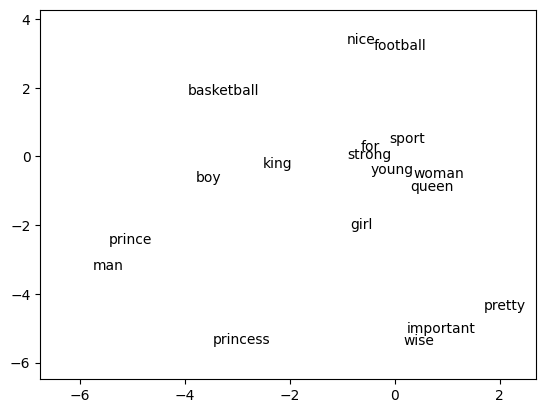

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for word, x1, x2 in zip(w2v_df['word'], w2v_df['x1'], w2v_df['x2']):
    ax.annotate(word, (x1,x2 ))

PADDING = 1.0
x_axis_min = np.amin(vectors, axis=0)[0] - PADDING
y_axis_min = np.amin(vectors, axis=0)[1] - PADDING
x_axis_max = np.amax(vectors, axis=0)[0] + PADDING
y_axis_max = np.amax(vectors, axis=0)[1] + PADDING

plt.xlim(x_axis_min,x_axis_max)
plt.ylim(y_axis_min,y_axis_max)
plt.rcParams["figure.figsize"] = (5,5)

plt.show()